In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import seaborn as sns

# Data exploration

In [2]:
# Path to the main dataset directory
data_dir = '/kaggle/input/pneumonia-radiography-dataset/Radiography/train/'

# Walk through directories to get image paths and labels
filepaths = []
labels = []
for dirpath, _, filenames in os.walk(data_dir):
    for filename in filenames:
        # Check for common image extensions
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(dirpath, filename)
            label = os.path.basename(dirpath)
            filepaths.append(filepath)
            labels.append(label)

# Create a DataFrame
df = pd.DataFrame({'filepath': filepaths, 'label': labels})

print(df.head())
print(f"\nTotal images: {len(df)}")

                                            filepath      label
0  /kaggle/input/pneumonia-radiography-dataset/Ra...  PNEUMONIA
1  /kaggle/input/pneumonia-radiography-dataset/Ra...  PNEUMONIA
2  /kaggle/input/pneumonia-radiography-dataset/Ra...  PNEUMONIA
3  /kaggle/input/pneumonia-radiography-dataset/Ra...  PNEUMONIA
4  /kaggle/input/pneumonia-radiography-dataset/Ra...  PNEUMONIA

Total images: 5216



Class Distribution:
label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64


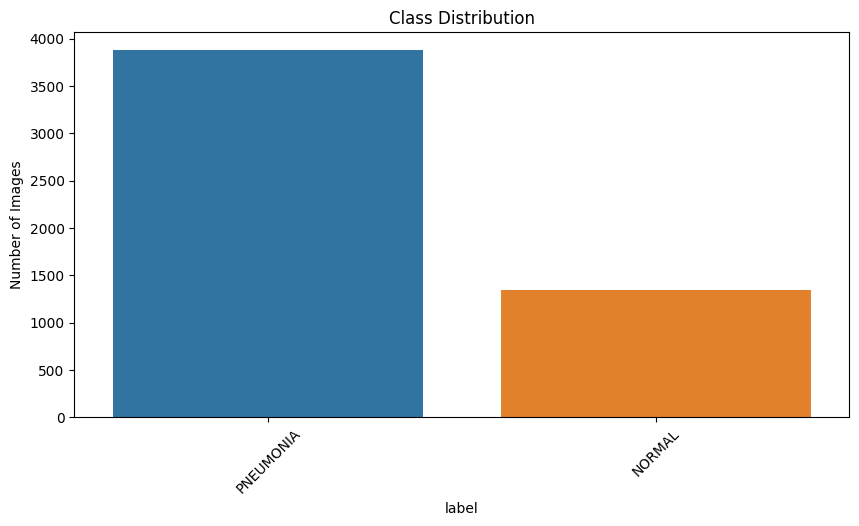

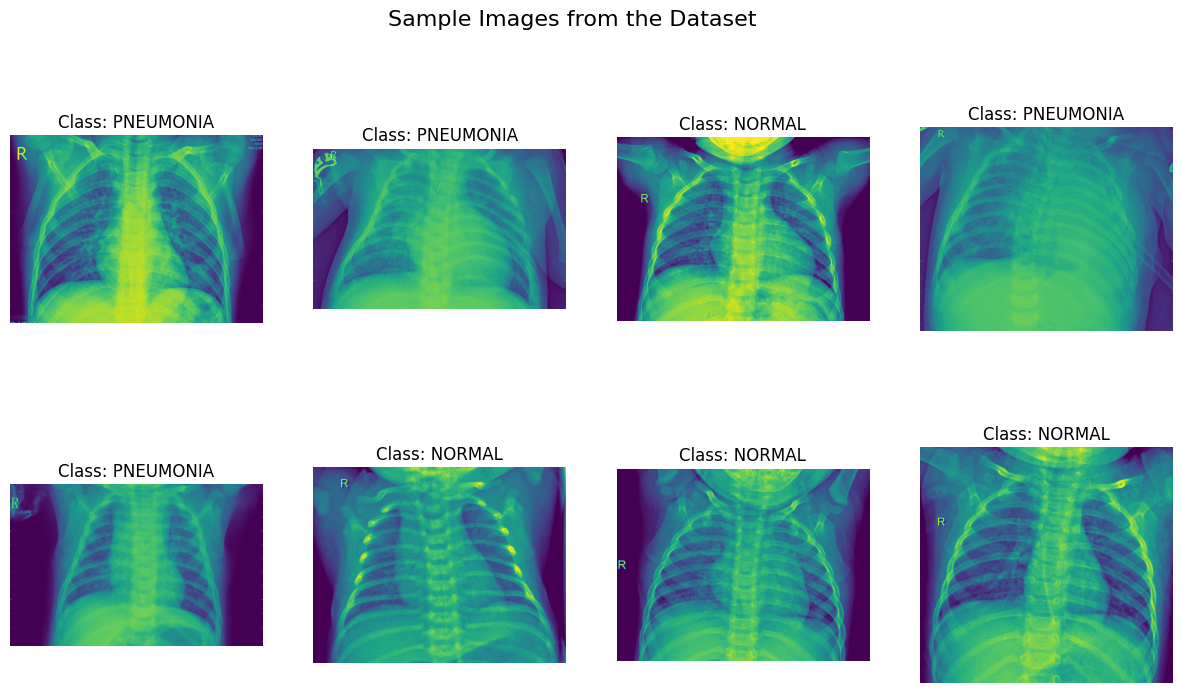

In [3]:
# Check class distribution
class_distribution = df['label'].value_counts()
print("\nClass Distribution:")
print(class_distribution)

# Visualize class distribution 📊
plt.figure(figsize=(10, 5))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# Display a sample of images 🖼️
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Sample Images from the Dataset', fontsize=16)
for i, ax in enumerate(axes.flat):
    # Get a random image
    sample = df.sample(1).iloc[0]
    img = Image.open(sample['filepath'])
    ax.imshow(img)
    ax.set_title(f"Class: {sample['label']}")
    ax.axis('off')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


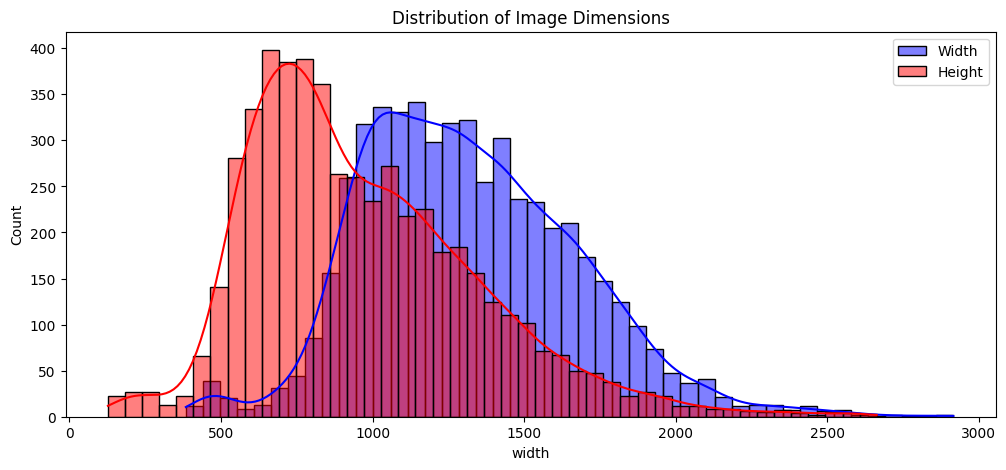

In [4]:
# Get image dimensions
heights = []
widths = []
for filepath in df['filepath']:
    try:
        with Image.open(filepath) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)
    except Exception as e:
        print(f"Could not read {filepath}: {e}") # Handle corrupted files

df['width'] = widths
df['height'] = heights

# Visualize image dimensions
plt.figure(figsize=(12, 5))
sns.histplot(df['width'], color='blue', label='Width', kde=True)
sns.histplot(df['height'], color='red', label='Height', kde=True)
plt.title('Distribution of Image Dimensions')
plt.legend()
plt.show()

In [5]:
# Get image modes
modes = [Image.open(filepath).mode for filepath in df['filepath']]
df['mode'] = modes

print("\nImage Mode Distribution:")
print(df['mode'].value_counts())


Image Mode Distribution:
mode
L      4933
RGB     283
Name: count, dtype: int64


# Data Preparation 

Successfully loaded 5216 image paths from '/kaggle/input/pneumonia-radiography-dataset/Radiography/train/'.
Successfully loaded 16 image paths from '/kaggle/input/pneumonia-radiography-dataset/Radiography/val/'.
Successfully loaded 485 image paths from '/kaggle/input/pneumonia-radiography-dataset/Radiography/test/'.

Label mapping created from training data: {'NORMAL': 0, 'PNEUMONIA': 1}
Training set: 5216 samples
Validation set: 16 samples
Test set: 485 samples

Calculated class weights for sampler:
label_idx
0    3.889635
1    1.346065
Name: count, dtype: float64

DataLoaders created successfully.
You are now ready to pass the loaders to your model training loop.


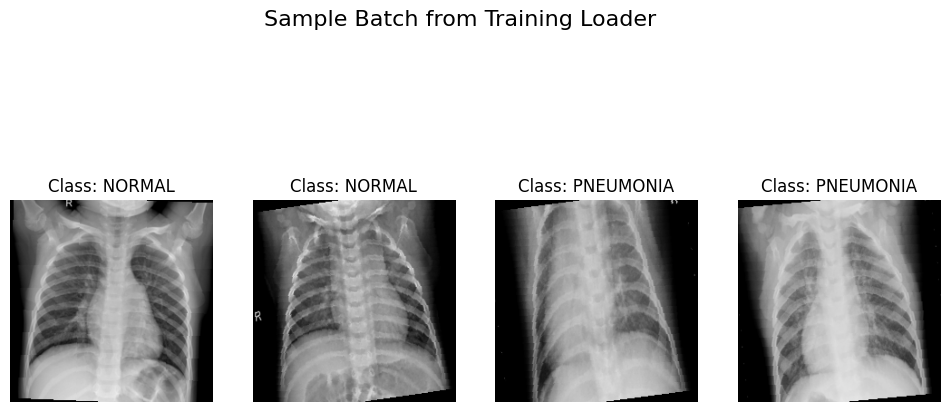

In [6]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# --- 1. Configuration ---
# IMPORTANT: Update these paths to point to your pre-split data folders.
TRAIN_DIR = '/kaggle/input/pneumonia-radiography-dataset/Radiography/train/'
VAL_DIR = '/kaggle/input/pneumonia-radiography-dataset/Radiography/val/'
TEST_DIR = '/kaggle/input/pneumonia-radiography-dataset/Radiography/test/'

IMAGE_SIZE = (224, 224) # ResNet50 standard input size
BATCH_SIZE = 32

# --- 2. Helper Function to Load Data from Directories ---
def load_data_from_directory(data_dir):
    """Walks through a directory to get image paths and labels."""
    try:
        filepaths = []
        labels = []
        for dirpath, _, filenames in os.walk(data_dir):
            # Ensure we are in a class sub-directory, not the root
            if dirpath == data_dir:
                continue
            for filename in filenames:
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    filepath = os.path.join(dirpath, filename)
                    label = os.path.basename(dirpath)
                    filepaths.append(filepath)
                    labels.append(label)
        
        if not filepaths:
            print(f"Warning: No images found in directory '{data_dir}'. Please check the path.")
            return pd.DataFrame()

        df = pd.DataFrame({'filepath': filepaths, 'label': labels})
        print(f"Successfully loaded {len(df)} image paths from '{data_dir}'.")
        return df

    except FileNotFoundError:
        print(f"Error: The directory '{data_dir}' was not found.")
        print("Please update the path variables (TRAIN_DIR, VAL_DIR, TEST_DIR).")
        return pd.DataFrame()

# --- 3. Load Data and Create DataFrames ---
train_df = load_data_from_directory(TRAIN_DIR)
val_df = load_data_from_directory(VAL_DIR)
test_df = load_data_from_directory(TEST_DIR)

# Proceed only if the training data was loaded successfully
if not train_df.empty:
    # --- 4. Create and Apply Consistent Label Mapping ---
    # Create the label-to-index map from the training data's unique labels.
    # This ensures consistency across all data splits.
    label_map = {label: i for i, label in enumerate(sorted(train_df['label'].unique()))}
    
    # Apply the mapping to all dataframes
    train_df['label_idx'] = train_df['label'].map(label_map)
    if not val_df.empty:
        val_df['label_idx'] = val_df['label'].map(label_map)
    if not test_df.empty:
        test_df['label_idx'] = test_df['label'].map(label_map)

    print("\nLabel mapping created from training data:", label_map)
    print(f"Training set: {len(train_df)} samples")
    print(f"Validation set: {len(val_df)} samples")
    print(f"Test set: {len(test_df)} samples")

    # --- 5. Define Data Augmentation and Preprocessing ---
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]

    train_transforms = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    val_test_transforms = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    # --- 6. Create a Custom PyTorch Dataset ---
    class XRayDataset(Dataset):
        def __init__(self, dataframe, transform=None):
            self.df = dataframe
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            img_path = self.df.iloc[idx]['filepath']
            label = self.df.iloc[idx]['label_idx']
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.long)

    # Create dataset instances
    train_dataset = XRayDataset(train_df, transform=train_transforms)
    if not val_df.empty:
        val_dataset = XRayDataset(val_df, transform=val_test_transforms)
    if not test_df.empty:
        test_dataset = XRayDataset(test_df, transform=val_test_transforms)

    # --- 7. Handle Class Imbalance with WeightedRandomSampler ---
    class_counts = train_df['label_idx'].value_counts().sort_index()
    num_samples = len(train_df)
    class_weights = num_samples / class_counts
    sample_weights = [class_weights[label] for label in train_df['label_idx']]
    sampler = WeightedRandomSampler(
        weights=torch.DoubleTensor(sample_weights),
        num_samples=num_samples,
        replacement=True
    )

    print("\nCalculated class weights for sampler:")
    print(class_weights)

    # --- 8. Create DataLoaders ---
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
    
    # Create validation and test loaders only if their dataframes are not empty
    val_loader = None
    if not val_df.empty:
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
    test_loader = None
    if not test_df.empty:
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"\nDataLoaders created successfully.")
    print("You are now ready to pass the loaders to your model training loop.")

    # --- 9. (Optional) Visualize a Batch of Training Data ---
    def imshow(inp, title=None):
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array(imagenet_mean)
        std = np.array(imagenet_std)
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.axis('off')

    try:
        inputs, classes = next(iter(train_loader))
        fig = plt.figure(figsize=(12, 6))
        for i in range(min(4, len(inputs))): # Ensure we don't go out of bounds
            ax = fig.add_subplot(1, 4, i + 1)
            imshow(inputs[i])
            class_name = [k for k, v in label_map.items() if v == classes[i]][0]
            ax.set_title(f"Class: {class_name}")
        plt.suptitle("Sample Batch from Training Loader", fontsize=16)
        plt.show()
    except Exception as e:
        print(f"\nCould not visualize batch. This might happen in some environments. Error: {e}")


# Build Model

Data loaders found. Proceeding with model training.


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s] 


ResNet50 model built successfully.
Epoch 1/10
----------


Train Phase: 100%|██████████| 163/163 [02:04<00:00,  1.31it/s]


Train Loss: 0.2599 Acc: 0.8978


Val Phase: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Val Loss: 0.4673 Acc: 0.6875
Saved Best Model!

Epoch 2/10
----------


Train Phase: 100%|██████████| 163/163 [02:02<00:00,  1.33it/s]


Train Loss: 0.1810 Acc: 0.9281


Val Phase: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Val Loss: 0.4067 Acc: 0.8125
Saved Best Model!

Epoch 3/10
----------


Train Phase: 100%|██████████| 163/163 [02:06<00:00,  1.29it/s]


Train Loss: 0.1700 Acc: 0.9333


Val Phase: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Val Loss: 0.2742 Acc: 0.8750
Saved Best Model!

Epoch 4/10
----------


Train Phase: 100%|██████████| 163/163 [02:05<00:00,  1.30it/s]


Train Loss: 0.1566 Acc: 0.9413


Val Phase: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Val Loss: 0.3716 Acc: 0.8125

Epoch 5/10
----------


Train Phase: 100%|██████████| 163/163 [02:06<00:00,  1.29it/s]


Train Loss: 0.1523 Acc: 0.9408


Val Phase: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Val Loss: 0.3640 Acc: 0.8750

Epoch 6/10
----------


Train Phase: 100%|██████████| 163/163 [02:06<00:00,  1.29it/s]


Train Loss: 0.1303 Acc: 0.9480


Val Phase: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Val Loss: 0.5242 Acc: 0.8125

Epoch 7/10
----------


Train Phase: 100%|██████████| 163/163 [02:05<00:00,  1.30it/s]


Train Loss: 0.1502 Acc: 0.9423


Val Phase: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Val Loss: 0.2308 Acc: 0.8750

Epoch 8/10
----------


Train Phase: 100%|██████████| 163/163 [02:07<00:00,  1.28it/s]


Train Loss: 0.1456 Acc: 0.9429


Val Phase: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Val Loss: 0.7448 Acc: 0.7500

Epoch 9/10
----------


Train Phase: 100%|██████████| 163/163 [02:06<00:00,  1.29it/s]


Train Loss: 0.1409 Acc: 0.9471


Val Phase: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Val Loss: 0.2667 Acc: 0.8125

Epoch 10/10
----------


Train Phase: 100%|██████████| 163/163 [02:06<00:00,  1.29it/s]


Train Loss: 0.1465 Acc: 0.9444


Val Phase: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Val Loss: 0.4050 Acc: 0.8750

Training complete in 21m 1s
Best val Acc: 0.875000

Evaluating final model on the test set...


Testing: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]



--- Classification Report ---
              precision    recall  f1-score   support

      NORMAL       0.93      0.85      0.88       234
   PNEUMONIA       0.87      0.94      0.90       251

    accuracy                           0.89       485
   macro avg       0.90      0.89      0.89       485
weighted avg       0.90      0.89      0.89       485


--- Confusion Matrix ---


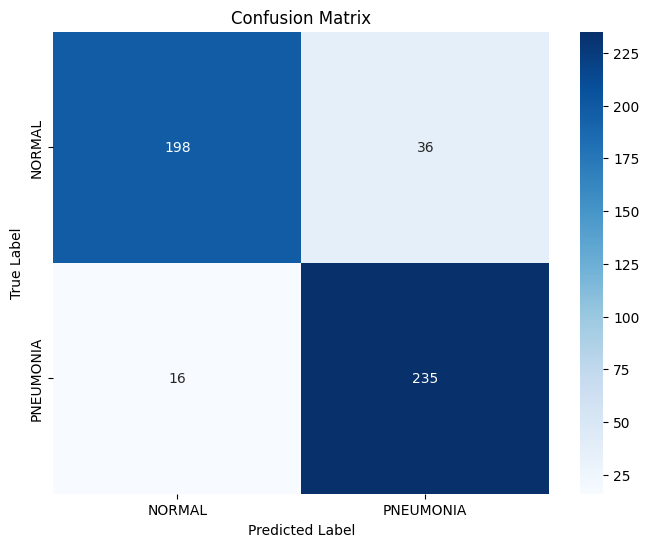

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import time
import copy
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

try:
    _ = train_loader, val_loader, test_loader, label_map
    print("Data loaders found. Proceeding with model training.")
except NameError:
    print("Data loaders not found. Creating placeholder loaders for demonstration.")
    print("Please run the data preparation script first for actual training.")
    # Create dummy data loaders if they don't exist
    dummy_dataset = torch.utils.data.TensorDataset(torch.randn(100, 3, 224, 224), torch.randint(0, 2, (100,)))
    train_loader = torch.utils.data.DataLoader(dummy_dataset, batch_size=32)
    val_loader = torch.utils.data.DataLoader(dummy_dataset, batch_size=32)
    test_loader = torch.utils.data.DataLoader(dummy_dataset, batch_size=32)
    label_map = {'NORMAL': 0, 'PNEUMONIA': 1}


# --- 1. Model Definition ---
def build_resnet50(num_classes):
    """
    Builds a ResNet50 model with a custom classifier for transfer learning.
    """
    # Load a pre-trained ResNet50 model
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

    # Freeze all the parameters in the pre-trained model
    for param in model.parameters():
        param.requires_grad = False

    # Get the number of input features for the classifier
    num_ftrs = model.fc.in_features

    # Replace the original fully connected layer with a new one
    # The new layer is trainable (requires_grad is True by default).
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    
    return model

# --- 2. Training and Evaluation Loop ---
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    """
    The main function to train and evaluate the model.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data using tqdm for a progress bar
            for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # Track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best one so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model
                torch.save(model.state_dict(), 'best_resnet50_model.pth')
                print("Saved Best Model!")

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# --- 3. Final Evaluation on Test Set ---
def evaluate_on_test_set(model, test_loader, label_map):
    """
    Evaluates the final model on the test set and prints a classification report.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval() # Set model to evaluation mode
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    class_names = list(label_map.keys())
    print("\n--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# --- 4. Main Execution Block ---
if __name__ == '__main__':
    # Configuration
    NUM_CLASSES = len(label_map)
    NUM_EPOCHS = 10 # You can increase this for better performance
    LEARNING_RATE = 0.001

    # Build the model
    model = build_resnet50(num_classes=NUM_CLASSES)
    print("ResNet50 model built successfully.")

    # Define loss function and optimizer
    # We only want to train the parameters of the new classifier head
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

    # Train the model
    trained_model, history = train_model(
        model, 
        criterion, 
        optimizer, 
        train_loader, 
        val_loader, 
        num_epochs=NUM_EPOCHS
    )
    
    # Evaluate the best model on the test set
    if test_loader:
        print("\nEvaluating final model on the test set...")
        evaluate_on_test_set(trained_model, test_loader, label_map)
    else:
        print("\nTest loader not found. Skipping final evaluation.")
